In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
# Import standard Adam from torch.optim
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup # We still use this scheduler

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm # For progress bars

print("Libraries imported successfully.")

Libraries imported successfully.


In [6]:
# --- Part 1: Data Acquisition (Hugging Face `ag_news`) & Initial Inspection ---

try:
    print("\n--- Part 1: Loading `ag_news` dataset from Hugging Face ---")
    dataset = load_dataset("ag_news")

    # The 'ag_news' dataset has 'train' and 'test' splits
    train_hf_dataset = dataset['train']
    test_hf_dataset = dataset['test']

    print(f"Loaded 'ag_news' dataset.")
    print(f"Train split size: {len(train_hf_dataset)} articles")
    print(f"Test split size: {len(test_hf_dataset)} articles")

    # Convert to Pandas DataFrames for easier initial inspection and preprocessing
    train_df = train_hf_dataset.to_pandas()
    test_df = test_hf_dataset.to_pandas()

    print("\nTrain DataFrame Head:")
    print(train_df.head())
    print("\nTrain DataFrame Columns:")
    print(train_df.columns.tolist())
    print("\nTrain DataFrame Info:")
    train_df.info()

    print("\nClass Distribution in Train Split:")
    # 'ag_news' labels are 0, 1, 2, 3. The dataset card says:
    # 0: World, 1: Sports, 2: Business, 3: Sci/Tech
    print(train_df['label'].value_counts())

except Exception as e:
    print(f"ERROR: Could not load `ag_news` dataset: {e}")
    print("Please ensure you have an active internet connection and `datasets` library is installed.")
    exit()


--- Part 1: Loading `ag_news` dataset from Hugging Face ---


Generating train split: 100%|█| 120000/120000 [00:00<00:00, 655537.54 examples/s
Generating test split: 100%|█████| 7600/7600 [00:00<00:00, 499165.52 examples/s]

Loaded 'ag_news' dataset.
Train split size: 120000 articles
Test split size: 7600 articles

Train DataFrame Head:
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2

Train DataFrame Columns:
['text', 'label']

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB

Class Distribution in Train Split:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


In [7]:
# --- Part 2: Preprocessing & Preparing Data for BERT ---

print("\n--- Part 2: Preprocessing & Preparing Data for BERT ---")

# 1. Map numerical labels to actual category names (for readability)
# Based on ag_news dataset card: 0: World, 1: Sports, 2: Business, 3: Sci/Tech
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
train_df['category_name'] = train_df['label'].map(label_map)
test_df['category_name'] = test_df['label'].map(label_map)

# Use LabelEncoder to ensure consistent integer labels (though ag_news already has them, good practice)
label_encoder = LabelEncoder()
# Fit on the full set of unique labels to ensure all are covered
all_labels = pd.concat([train_df['category_name'], test_df['category_name']]).unique()
label_encoder.fit(all_labels)

train_labels_encoded = label_encoder.transform(train_df['category_name'])
test_labels_encoded = label_encoder.transform(test_df['category_name'])
num_labels = len(label_encoder.classes_)

print(f"\nNumber of unique labels: {num_labels}")
print(f"Label classes: {label_encoder.classes_}")


# 2. Split a small validation set from the training data (optional but good practice)
# ag_news already provides a test set, so we'll just split train for validation.
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_labels_encoded,
    test_size=0.1, # 10% of training data for validation
    random_state=42,
    stratify=train_labels_encoded # Important to maintain class distribution
)
test_texts = test_df['text'].tolist()
test_labels = test_labels_encoded


# 3. Load BERT Tokenizer
model_name = 'bert-base-uncased' # A good general-purpose BERT model
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"\nBERT Tokenizer '{model_name}' loaded.")


# 4. Create Custom Dataset Class for PyTorch
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Use encode_plus for comprehensive encoding
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,        # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,        # Pad/truncate all texts to max_len
            return_token_type_ids=True,     # Return token type IDs (segment IDs)
            padding='max_length',           # Pad to max_len
            truncation=True,                # Truncate to max_len
            return_attention_mask=True,     # Return attention mask
            return_tensors='pt',            # Return PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define hyperparameters for data preparation
MAX_LEN = 128 # Max sequence length (adjust if your articles are very long/short after inspection)
BATCH_SIZE = 16 # Adjust based on your GPU/RAM (16, 32, 64 are common)

# Create Dataset and DataLoader instances
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nDataLoaders created with MAX_LEN={MAX_LEN}, BATCH_SIZE={BATCH_SIZE}.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Quick check of a batch
try:
    batch = next(iter(train_loader))
    print(f"\nSample batch shapes - input_ids: {batch['input_ids'].shape}, labels: {batch['labels'].shape}")
    print(f"Sample labels: {batch['labels'].tolist()}")
except Exception as e:
    print(f"ERROR: Could not get a sample batch from DataLoader: {e}")


--- Part 2: Preprocessing & Preparing Data for BERT ---

Number of unique labels: 4
Label classes: ['Business' 'Sci/Tech' 'Sports' 'World']

BERT Tokenizer 'bert-base-uncased' loaded.

DataLoaders created with MAX_LEN=128, BATCH_SIZE=16.
Number of training batches: 6750
Number of validation batches: 750
Number of test batches: 475

Sample batch shapes - input_ids: torch.Size([16, 128]), labels: torch.Size([16])
Sample labels: [3, 3, 2, 2, 0, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 2]


In [8]:
# --- Part 3: Load BERT Model & Fine-tuning ---

print("\n--- Part 3: Load BERT Model & Fine-tuning ---")

# 1. Load Pre-trained BERT Model for Sequence Classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Set up device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")


--- Part 3: Load BERT Model & Fine-tuning ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [11]:
# 2. Define Training Parameters (MODIFIED OPTIMIZER)
EPOCHS = 3
LEARNING_RATE = 2e-5 # Keep a similar learning rate
# Adam has a `weight_decay` parameter directly in its constructor for L2 regularization.
# Common values for weight_decay for Adam are 0.01 or 0.
# For AdamW, weight decay is applied *after* the update, for Adam, it's *during* the update.
WEIGHT_DECAY = 0.01 # L2 regularization

# Using torch.optim.Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # No warm-up for simplicity
    num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [12]:
# 3. Define Training and Evaluation Functions (no changes needed, as they use optimizer.step() etc.)
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        losses.append(loss.item())

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [13]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            losses.append(loss.item())

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [14]:
# 4. Run Fine-tuning Loop
history = []
best_accuracy = 0.0

print("\n--- Starting Fine-tuning Loop ---")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)

    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc.item(),
        'val_loss': val_loss,
        'val_acc': val_acc.item()
    })

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_bert_classifier_agnews_adam.pth') # Changed filename
        best_accuracy = val_acc
        print("Saved best model state_dict.")

print("\nFine-tuning complete.")



--- Starting Fine-tuning Loop ---

Epoch 1/3


Evaluating: 100%|█████████████████████████████| 750/750 [01:20<00:00,  9.28it/s]


Train loss: 0.5813, Train accuracy: 0.8104
Validation loss: 0.5511, Validation accuracy: 0.8352
Saved best model state_dict.

Epoch 2/3


Evaluating: 100%|█████████████████████████████| 750/750 [01:21<00:00,  9.24it/s]


Train loss: 0.7743, Train accuracy: 0.7225
Validation loss: 0.7656, Validation accuracy: 0.6787

Epoch 3/3


Evaluating: 100%|█████████████████████████████| 750/750 [01:20<00:00,  9.28it/s]

Train loss: 0.7794, Train accuracy: 0.7034
Validation loss: 0.7356, Validation accuracy: 0.7088

Fine-tuning complete.



--- Part 4: Evaluation on Test Set ---
Loaded best model for evaluation.


Predicting on Test Set: 100%|█████████████████| 475/475 [00:51<00:00,  9.17it/s]



--- Classification Report on Test Set ---
              precision    recall  f1-score   support

    Business       0.81      0.75      0.78      1900
    Sci/Tech       0.74      0.78      0.76      1900
      Sports       0.94      0.95      0.94      1900
       World       0.82      0.82      0.82      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



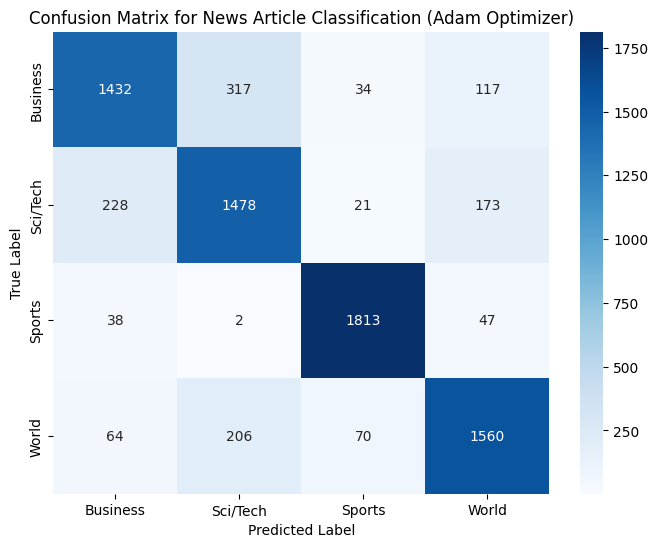


--- Part 5: Inference on New Text ---

New Article 1: 'Scientists have made a breakthrough in fusion energy, promising clean power for the future.'
Predicted Category: Sci/Tech (Confidence: 0.70)

New Article 2: 'Nepal's tourism industry is set to recover strongly as international arrivals surge.'
Predicted Category: Sci/Tech (Confidence: 0.70)

New Article 3: 'Real Madrid triumphed over Barcelona in a thrilling El Clásico match.'
Predicted Category: Sports (Confidence: 0.85)

New Article 4: 'The latest smartphone boasts a revolutionary new camera system and faster processor.'
Predicted Category: Sci/Tech (Confidence: 0.68)


In [15]:
# --- Part 4: Evaluation on Test Set (MODIFIED FILENAME) ---

print("\n--- Part 4: Evaluation on Test Set ---")

try:
    model.load_state_dict(torch.load('best_bert_classifier_agnews_adam.pth')) # Changed filename
    model.to(device)
    model.eval()
    print("Loaded best model for evaluation.")
except FileNotFoundError:
    print("ERROR: 'best_bert_classifier_agnews_adam.pth' not found. Did the training complete successfully?")
    exit()

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting on Test Set"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
    return predictions, true_labels

test_preds, test_true_labels = get_predictions(model, test_loader, device)

print("\n--- Classification Report on Test Set ---")
print(classification_report(test_true_labels, test_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(test_true_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for News Article Classification (Adam Optimizer)')
plt.show()

# --- Part 5: Inference on New Text (MODIFIED FILENAME) ---
# (No changes needed in this part, it will use the loaded model)

print("\n--- Part 5: Inference on New Text ---")

def predict_news_category(text, model, tokenizer, label_encoder, device, max_len=128):
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)

    predicted_category = label_encoder.inverse_transform(predicted_class.cpu().numpy())[0]
    confidence = probabilities.max().item()

    return predicted_category, confidence

new_article_1 = "Scientists have made a breakthrough in fusion energy, promising clean power for the future."
category_1, confidence_1 = predict_news_category(new_article_1, model, tokenizer, label_encoder, device)
print(f"\nNew Article 1: '{new_article_1}'")
print(f"Predicted Category: {category_1} (Confidence: {confidence_1:.2f})")

new_article_2 = "Nepal's tourism industry is set to recover strongly as international arrivals surge."
category_2, confidence_2 = predict_news_category(new_article_2, model, tokenizer, label_encoder, device)
print(f"\nNew Article 2: '{new_article_2}'")
print(f"Predicted Category: {category_2} (Confidence: {confidence_2:.2f})")

new_article_3 = "Real Madrid triumphed over Barcelona in a thrilling El Clásico match."
category_3, confidence_3 = predict_news_category(new_article_3, model, tokenizer, label_encoder, device)
print(f"\nNew Article 3: '{new_article_3}'")
print(f"Predicted Category: {category_3} (Confidence: {confidence_3:.2f})")

new_article_4 = "The latest smartphone boasts a revolutionary new camera system and faster processor."
category_4, confidence_4 = predict_news_category(new_article_4, model, tokenizer, label_encoder, device)
print(f"\nNew Article 4: '{new_article_4}'")
print(f"Predicted Category: {category_4} (Confidence: {confidence_4:.2f})")